<a href="https://colab.research.google.com/github/mosameh2002/ml1/blob/main/ML1project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

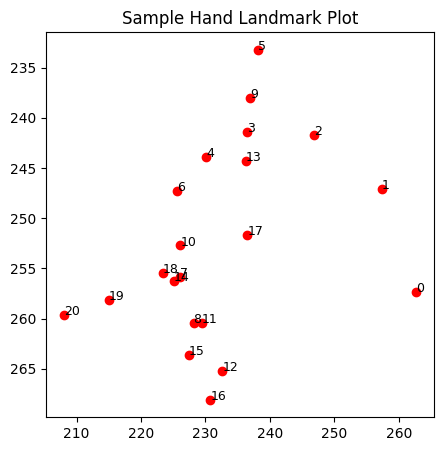

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import cv2
import mediapipe as mp
from collections import deque, Counter

data = pd.read_csv("hand_landmarks_data.csv")

labels = data['label']
features = data.drop('label', axis=1)

wrist_x = features['x1']
wrist_y = features['y1']

for i in range(1, 22):
    features[f'x{i}'] = features[f'x{i}'] - wrist_x
    features[f'y{i}'] = features[f'y{i}'] - wrist_y

finger_tip_x = features['x13']
finger_tip_y = features['y13']

for i in range(1, 22):
    features[f'x{i}'] = features[f'x{i}'] / finger_tip_x.replace(0, 1e-6)
    features[f'y{i}'] = features[f'y{i}'] / finger_tip_y.replace(0, 1e-6)

X = features.values

le = LabelEncoder()
y = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

sample = data.iloc[0]
landmark_x = [sample[f'x{i}'] for i in range(1, 22)]
landmark_y = [sample[f'y{i}'] for i in range(1, 22)]

plt.figure(figsize=(5, 5))
plt.scatter(landmark_x, landmark_y, c='red')
for i in range(21):
    plt.text(landmark_x[i], landmark_y[i], str(i), fontsize=9)
plt.gca().invert_yaxis()
plt.title("Sample Hand Landmark Plot")
plt.show()

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

cap = cv2.VideoCapture(1)

hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)
prediction_window = deque(maxlen=10)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(frame_rgb)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            landmark_list = []
            for lm in hand_landmarks.landmark:
                landmark_list.extend([lm.x, lm.y, lm.z])

            landmark_array = np.array(landmark_list).reshape(21, 3)

            wrist = landmark_array[0]
            fingertip = landmark_array[12]
            landmark_array[:, :2] -= wrist[:2]
            landmark_array[:, 0] /= fingertip[0] if fingertip[0] != 0 else 1e-6
            landmark_array[:, 1] /= fingertip[1] if fingertip[1] != 0 else 1e-6

            input_data = landmark_array.flatten().reshape(1, -1)
            input_data = scaler.transform(input_data)

            pred = model.predict(input_data)[0]
            label = le.inverse_transform([pred])[0]
            prediction_window.append(label)

            stabilized = Counter(prediction_window).most_common(1)[0][0]

            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            cv2.putText(frame, stabilized, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow('Hand Gesture Classification', frame)
    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()

<IPython.core.display.Javascript object>

📸 Click the 'Capture Photo' button above and wait for prediction...
Predicted Gesture: fist


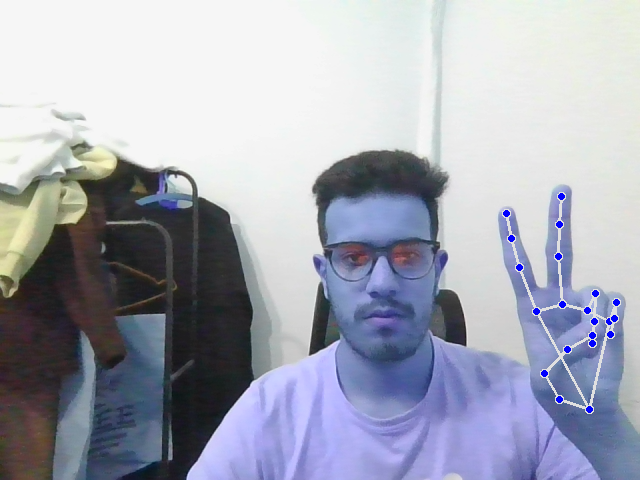

In [ ]:
import pandas as pd
import numpy as np
import cv2
import mediapipe as mp
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display, Javascript
from google.colab.output import register_callback, eval_js
from base64 import b64decode
import io
from google.colab.patches import cv2_imshow

data = pd.read_csv("hand_landmarks_data.csv")
labels = data['label']
features = data.drop('label', axis=1)

for i in range(1, 22):
    features[f'x{i}'] -= features['x1']
    features[f'y{i}'] -= features['y1']
    features[f'x{i}'] /= features['x13'].replace(0, 1e-6)
    features[f'y{i}'] /= features['y13'].replace(0, 1e-6)

X = features.values
le = LabelEncoder()
y = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

def take_photo():
    display(Javascript('''
        async function takePhoto() {
            const div = document.createElement('div');
            const video = document.createElement('video');
            const button = document.createElement('button');
            button.textContent = 'Capture Photo';

            div.appendChild(video);
            div.appendChild(button);
            document.body.appendChild(div);

            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await video.play();

            const canvas = document.createElement('canvas');
            const context = canvas.getContext('2d');

            button.onclick = () => {
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                context.drawImage(video, 0, 0);
                stream.getTracks().forEach(track => track.stop());
                const dataURL = canvas.toDataURL('image/png');
                google.colab.kernel.invokeFunction('notebook.getImage', [dataURL], {});
                div.remove();
            };
        }
        takePhoto();
    '''))

def get_image_callback(data_url):
    header, encoded = data_url.split(',', 1)
    binary = b64decode(encoded)
    global img
    img = Image.open(io.BytesIO(binary))

register_callback('notebook.getImage', get_image_callback)

take_photo()
print("📸 Click the 'Capture Photo' button above and wait for prediction...")

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

try:
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    results = hands.process(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            coords = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])
            coords[:, :2] -= coords[0, :2]
            coords[:, 0] /= coords[12, 0] if coords[12, 0] != 0 else 1e-6
            coords[:, 1] /= coords[12, 1] if coords[12, 1] != 0 else 1e-6

            input_data = scaler.transform(coords.flatten().reshape(1, -1))
            pred = model.predict(input_data)[0]
            label = le.inverse_transform([pred])[0]

            print(f"Predicted Gesture: {label}")
            mp_drawing.draw_landmarks(img_cv, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    cv2_imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
except NameError:
    print("Please run the cell again after capturing an image.")
